# Two-player Monte Carlo Game
This notebook describes the code from the second half of chapter 6 in Applied Mathematics for Security. It uses the previously defined Monte Carlo Simulation to create a two player game representing an adversarial network scenario. The goal is to create a simulation which tests player two's ability to disrupt the network by removing communication edges.

The first few cells hold the majority of the functions described in the text. I've copied the user_to_series function used in chapter 5. Some of the background functions reside in the graph_funcs.py file which gets imported as ext

In [1]:
import json
import networkx as nx
from random import choice, random
import pandas as pd
import graph_funcs as ext
import scipy.stats as stats
import numpy as np
from matplotlib import pyplot as plt

def user_to_series(dict_obj):
    """Convert a nested JSON user to a flat pandas series"""
    renamed = {}
    for k in dict_obj.keys():
        nk = "user_%s" % k
        v = dict_obj[k]
        renamed[nk] = v
    ret = pd.Series(renamed)
    return ret

# I know there are better ways to do this but I was in a rush to get it done
def add_reply_username(df):
    out = []
    for uid in list(df["in_reply_to_account_id"].values):
        if uid is None:
            out.append(np.nan)
            continue
        user_name = df[df["user_id"]==uid]["user_screen_name"].values[0]
        out.append(user_name)
    copy = df.copy()
    copy["in_repy_to_screen_name"] = out
    return copy

The ncap_weights function creates a weight list for the neighbors of a node in the graph based on their capacity to transmit the message. This is similar behavior to how packet switching networks decide what routes packets should traverse to reach their destination.

In [2]:
# From Listing 6-10
def ncap_weights(G, u):
    u_in = list(G.in_edges(u, data=True))
    if len(u_in) < 1:
        return (None, None)
    n_capacity = {}
    for v,u,d in u_in:
        n_capacity[v] = d["capacity"]
    Q = 1 + max([itm[1] for itm in list(n_capacity.items())])
    n_weight = {k: (Q - n_capacity[k]) for k in n_capacity.keys()}
    return (n_capacity, n_weight)

The wrs_connect and wrs_disconnect functions handle adding and removing selected edges as the network evolves over time.

In [3]:
# From Listing 6-9
def wrs_connect(G, u):
    scores = {}
    for i in range(len(G.nodes.keys())):
        v = list(G.nodes.keys())[i]
        if v == u:
            continue
        dpa_score = G.out_degree(u) * G.in_degree(v)      
        scores[v] = dpa_score
    return ext.weighted_choice(scores)

# From Listing 6-11
def wrs_disconnect(G, u):
    u_in = list(G.in_edges(u))
    if len(u_in) < 1:
        #print("%s has noone to disconnect" % u)
        return None
    caps, scores = ncap_weights(G, u)
    if scores is not None:
        return ext.weighted_choice(scores)

The shortest_path_scores function returns a list of average path lengths for all pairs of nodes which are not directly connected 

In [4]:
# From Listing 6-14
def shortest_path_scores(G):
    pairs = []
    for u, v in nx.non_edges(G):
        if u == v:
            continue
        if not nx.has_path(G, u, v):
            continue
        uv_paths = list(nx.all_shortest_paths(G, u, v))
        avg_len = sum([len(p) for p in uv_paths]) / len(uv_paths)
        pairs.append(((u, v), len(uv_paths), avg_len))
        #print(((u, v), len(uv_paths), avg_len))
    sorted_scores = sorted(
        pairs,
        key=lambda kv: (kv[2], kv[1], kv[0]),
        reverse=True
    )
    return sorted_scores

Finally the check_win function runs at the end of each player's turn to see if they were able to put the network in a terminal state. if the message has not reached the sink node and there is no path between the current locate and the destination, then player two wins. If the message reaches the destination node then Player one wins. The win function is known as 0-sum because we score one player with +1 and the other player with -1, and when you add those together, you get 0.

In [5]:
# From Listing 6-6
def check_win(G, uq, omega):
    if uq != omega and nx.has_path(G, uq, omega):
        return None
    elif uq == omega:
        return 1
    elif not nx.has_path(G, uq, omega):
        return -1

The next cell wraps the code from listing 6-15 in a convenient function definition which can be called in a loop to rerun the simulation multiple times or with varying parameters

In [6]:
# From Listing 6-15
def simulate(G,num_samples=25,num_sims=25,num_steps=10, rand_player=True):
    path_scores = shortest_path_scores(G)
    path_weights = {(p[0][0], p[0][1]): p[2] for p in path_scores}
    played = []
    pop_avgs = []
    for r in range(num_samples):
        selected = ext.weighted_choice(path_weights)
        while selected in played:
            # pick a different pair of nodes
            selected = ext.weighted_choice(path_weights)
        played.append(selected)
        #print(selected, path_weights[selected])
        alpha = selected[0] # Starting Node
        omega = selected[1] # Goal Node
        game_res = [] # Holds the result of each simulation
        for i in range(num_sims):
            newG = G.copy() # Copy the base graph for a new game
            now_at = alpha
            for j in range(num_steps):
                w = check_win(newG, now_at, omega)
                if w is not None:
                    game_res.append(w)
                    break
                now_at, newG = player_one_turn(newG, now_at, omega)
                if not check_win(newG, now_at, omega):
                    if rand_player:
                        newG = player_two_random(newG)
                    else:
                        newG = player_two_turn(newG, now_at, omega)
        tally = sum(game_res)
        avg = tally / len(game_res)
        pop_avgs.append(float(avg))
        print(f"Sample {r}: Average {avg}")
    return pop_avgs

# Player One function
The code for player one handles evolving the network over time. On each turn player one iterates over every member of the network deciding if they create a new connection, pass, or disconnect from someone in the network. in this way player 1 acts as the natural evolution of the network and doesn't really get to interfere with player two.

In [7]:
# From Listing 6-12
def player_one_turn(G, uq, omega):
    if G.has_edge(uq, omega):
        #print("goal node in edges")
        return (omega, G)
    caps = [d["capacity"] for u,v,d in G.edges(data=True)]
    avg_cap = sum(caps) / len(caps)
    
    for u in list(G.nodes.keys()):
        if u == uq:
            try:
                paths = list(nx.all_shortest_paths(G, u, omega))                
            except nx.exception.NetworkXNoPath:
                #print("No path between %s and %s" % (uq, omega))
                return (uq, G)
            path = choice(paths)
            #print("path to goal", path)
            pass_to = path[1]
        else:
            act = ext.weighted_choice(XI)
            if act == "pass":
                continue
            elif act == "connect":
                v_conn = wrs_connect(G, u)
                #print("connecting %s to %s" % (u, v_conn))
                G.add_edge(u, v_conn, capacity=avg_cap)
            else:
                v_disconn = wrs_disconnect(G, u)
                if v_disconn is None:
                    continue
                #print("%s disconnecting from" % u, v_disconn)
                G.remove_edge(v_disconn, u)
    return (pass_to, G)

# Player Two functions
There are two versions of player two. The first is an random player two which randomly chooses an edge to remove from G without any contextual information. We attempt to improve the performance of the player by adding information related to the cut set theorem described in the chapter.

In [8]:
# From Listing 6-13
def player_two_random(G):
    e = choice(list(G.edges()))
    G.remove_edge(*e)
    return G
    
# From Listing 6-16
def player_two_turn(G, uq, omega):
    cut_value, partition = nx.minimum_cut(G, uq, omega)
    reachable, unreachable = partition
    cutset = set()
    for u, nbrs in ((n, G[n]) for n in reachable):
        cutset.update((u, v) for v in nbrs if v in unreachable)
    caps, scores = ncap_weights(G, omega)
    if len(cutset) >= 2:
        cut = choice(list(cutset))
        G.remove_edge(*cut)
    elif len(cutset) == 1:
        #print("Single cut to disconnect %s from %s" % (uq, omega))
        cut = list(cutset)[0]
        G.remove_edge(*cut)
    return G

# Configuring the simulation
The variables in the next cell control the transition weights in XI as well as the number of steps, simulations and retests you'd like to run. These are the variables you may want to play with.
I've added the retests variable to replace the magic number in the text.

In [9]:
# Transition weights. The key space for connect and pass will each be 2/5 and disconnect will be 1/5
XI = {
    "connect": 2,
    "disconnect": 1,
    "pass": 2
}

retests = 25 # number of times to resample the simulation to create the test population
k = 10 # number of simulations per game
n = 10 # number of steps per simulation
confidence_in_mean = 0.95 # Confidence to use when predicting the population mean
confidence_in_conclusion = 0.99 # Confidence level used to reject the null hypothesis
################################################

# Running the Simulations

We begin by loading the source data. This is the same as in the previous chapter. We load the tweet data from JSON objects, and convert them into a Pandas DataFrame which we then use to create the graph object's nodes and edges.

In [10]:
############### Build the network Graph ###############
G = nx.DiGraph()

# process the toot data to create the network
series_data = [] # 1 JSON object per toot object
with open("fake_toots.json") as data:
    text = data.read().strip()
    rows = text.split("\n")  # JSON objects stored as list of strings
for row in rows:
    obj = json.loads(row) # Converted row string to JSON object
    series_data.append(obj) # Add to JSON list

toot_df = pd.DataFrame(series_data) # 1 row per JSON obj
toot_df = pd.concat([toot_df, toot_df['account'].apply(user_to_series)], axis=1)
toot_df = add_reply_username(toot_df)
# Now the data is flattened. We remove the field containing the JSON object
toot_df.drop("account", axis=1, inplace=True)
toot_df.dropna(axis=0, inplace=True)
toot_df["in_reply_to_id"] = toot_df["in_reply_to_id"].astype(int)
toot_df["in_reply_to_user_id"] = toot_df["in_reply_to_user_id"].astype(int)
toot_df["user_id"] = toot_df["user_id"].astype(int)

for idx in toot_df.index:
    row = toot_df.loc[idx]
    u = row["in_reply_to_screen_name"]
    v = row["user_screen_name"]
    w = len(row["text"])
    if G.has_edge(u,v):
        G[u][v]["capacity"] += w
    else:
        G.add_edge(u, v, capacity=w)

With the graph built and the simulation parameters defined we can start to run the code and collect data. First we need to establish a baseline performance to score against using a "dumb" player who selects random moves. The next cell uses the simulate function to run the Monte Carlo simulation the number of times defined in the retests variable. Each test will be composed of k walks of length n (or less if a terminal state is reached). We then use the sample mean from each retest to derive a confidence interval for the population mean.

In [11]:
############### Begin Running the simulations ###############
# Create the base line with the random player
print("Testing Random Player 2 strategy:")
rand_p2_avgs = simulate(G,num_samples=retests,num_sims=k,num_steps=n, rand_player=True)
rand_p2_pop_avg = np.mean(rand_p2_avgs)
print(f"Random Player 2 Population Average {rand_p2_pop_avg}")
#create confidence interval for random player 2 population mean
rand_p2_pop_interval = stats.t.interval(
    alpha=confidence_in_mean,
    df=len(rand_p2_avgs)-1,
    loc=np.mean(rand_p2_avgs),
    scale=stats.sem(rand_p2_avgs)
)
print(f"Random Player 2 Interval {rand_p2_pop_interval}")

Testing Random Player 2 strategy:
Sample 0: Average 0.0
Sample 1: Average 0.6
Sample 2: Average 0.2
Sample 3: Average -0.4
Sample 4: Average 0.0
Sample 5: Average 0.5555555555555556
Sample 6: Average 0.8
Sample 7: Average 0.0
Sample 8: Average 0.6
Sample 9: Average -0.6
Sample 10: Average 0.4
Sample 11: Average 0.2
Sample 12: Average 0.2
Sample 13: Average -0.8
Sample 14: Average 0.2
Sample 15: Average 0.2
Sample 16: Average 0.8
Sample 17: Average -0.4
Sample 18: Average -0.4
Sample 19: Average -0.2
Sample 20: Average 0.2
Sample 21: Average 0.0
Sample 22: Average 0.2
Sample 23: Average -0.6
Sample 24: Average -0.8
Random Player 2 Population Average 0.03822222222222222
Random Player 2 Interval (-0.1545087489152458, 0.23095319335969022)


# Improved Player Two
We can now rerun the simulation with a more intelligent version of player two. Sending rand_player=False to the simulate function will change the underlying logic for player two from the player_two_random function to the player_two_turn function which contains the logic described in the text.

In [12]:
# Create the improved player's data
print("Testing Smarter Player 2 strategy:")
smart_p2_avgs = simulate(G,num_samples=retests,num_sims=k,num_steps=n, rand_player=False)
smart_p2_pop_avg = np.mean(smart_p2_avgs)
print(f"Smart Player 2 Population Average {smart_p2_pop_avg}")
#create confidence interval for smart player 2 population mean
smart_p2_pop_interval = stats.t.interval(
    alpha=confidence_in_mean,
    df=len(smart_p2_avgs)-1,
    loc=np.mean(smart_p2_avgs),
    scale=stats.sem(smart_p2_avgs)
)
print(f"Smart Player 2 Interval {smart_p2_pop_interval}")

Testing Smarter Player 2 strategy:
Sample 0: Average -0.6
Sample 1: Average -1.0
Sample 2: Average -1.0
Sample 3: Average -1.0
Sample 4: Average -1.0
Sample 5: Average -1.0
Sample 6: Average -0.8
Sample 7: Average -1.0
Sample 8: Average -1.0
Sample 9: Average -1.0
Sample 10: Average -1.0
Sample 11: Average -0.8
Sample 12: Average -0.2
Sample 13: Average -1.0
Sample 14: Average -1.0
Sample 15: Average -0.8
Sample 16: Average -0.2
Sample 17: Average -1.0
Sample 18: Average -0.2
Sample 19: Average -1.0
Sample 20: Average -1.0
Sample 21: Average -1.0
Sample 22: Average -0.6
Sample 23: Average -1.0
Sample 24: Average -1.0
Smart Player 2 Population Average -0.848
Smart Player 2 Interval (-0.9604903608525566, -0.7355096391474434)


We can now compare the two population samples using a one tailed T-Test. our hypothesis is that the change to player two's strategy will create an increase in the likelihood they will win the game. We would see this as a marked decrease in the populating score mean. The null hypothesis is therefore that the improved player two will not create a significantly lower population score than the random player. 

In [13]:
# Run the one-tailed T-Test. We are asserting the random player's mean 
# will be strictly greater than the mean of the improved player's
ttest_score = abs(stats.ttest_ind(rand_p2_avgs, smart_p2_avgs, alternative='greater').pvalue)
thresh = 1-confidence_in_conclusion
if thresh < ttest_score:
    print("We cannot reject the null hypothesis. No significant difference detected.")
else:
    print("We can reject the null hypothesis. The two samples are significantly different")

We can reject the null hypothesis. The two samples are significantly different


We can also visualize the change in population means by plotting their distribution curves. The next cell creates two normal distribution curves based on the statistics gathered for both the random and improved players and plots them together.

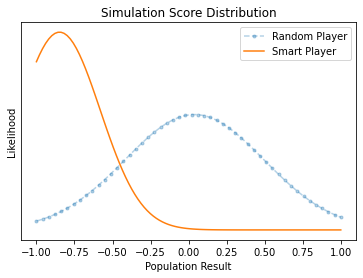

In [14]:
xmin = -1 # no game can score lower than -1
xmax = 1 # no game can score higher than +1
X1 = stats.norm(np.mean(rand_p2_avgs), np.std(rand_p2_avgs)) # Random Player normal distribution
xs1 = np.linspace(xmin,xmax,50)  # create 100 x values in that range
plt.plot(xs1,X1.pdf(xs1), "--.", alpha=0.33) # plot the shape of the distribution

X2 = stats.norm(np.mean(smart_p2_avgs), np.std(smart_p2_avgs)) # Smart Player normal distribution
xs2 = np.linspace(xmin,xmax,100)  # create 100 x values in that range
plt.plot(xs2,X2.pdf(xs2)) # plot the shape of the distribution
plt.legend(["Random Player", "Smart Player"])
plt.yticks([])
plt.ylabel("Likelihood")
plt.xlabel("Population Result")
plt.title("Simulation Score Distribution")
#plt.savefig("Figure_6-4.png")
#plt.savefig("Figure_6-4.svg", format="svg")
plt.show()